# 06 - Classificando patologias em toras usando combinação de `OTSU_treshold + LBP + SVM` e normalizando amostras pelo maior elemento de cada histograma

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'broca': 0,
                'fissura': 1,
                'musgo': 2,
                'quebra': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pelo maior elemento do histograma
    arr /= arr.max()

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_norm2_toras.csv')
data

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.001652,0.003402,0.0,0.000486,0.0,0.002722,0.0,0.000972,0.0,0.0,...,0.0,0.005540,0.0,0.004471,0.0,0.004277,0.0,1.0,0.013802,0
1,0.002474,0.003689,0.0,0.001439,0.0,0.003644,0.0,0.001439,0.0,0.0,...,0.0,0.006073,0.0,0.004498,0.0,0.004948,0.0,1.0,0.026629,0
2,0.000299,0.000769,0.0,0.000641,0.0,0.000812,0.0,0.000427,0.0,0.0,...,0.0,0.003418,0.0,0.005426,0.0,0.005682,0.0,1.0,0.006323,0
3,0.000027,0.000027,0.0,0.000151,0.0,0.000014,0.0,0.000110,0.0,0.0,...,0.0,0.001401,0.0,0.002432,0.0,0.001882,0.0,1.0,0.000769,0
4,0.002808,0.005140,0.0,0.003284,0.0,0.005331,0.0,0.003712,0.0,0.0,...,0.0,0.009471,0.0,0.011613,0.0,0.010328,0.0,1.0,0.038456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.000446,0.001962,0.0,0.001427,0.0,0.002318,0.0,0.001159,0.0,0.0,...,0.0,0.007847,0.0,0.005439,0.0,0.010789,0.0,1.0,0.018636,3
1188,0.001723,0.004344,0.0,0.002247,0.0,0.004419,0.0,0.001872,0.0,0.0,...,0.0,0.005842,0.0,0.002322,0.0,0.004344,0.0,1.0,0.038122,3
1189,0.001011,0.001390,0.0,0.002023,0.0,0.001770,0.0,0.001390,0.0,0.0,...,0.0,0.012514,0.0,0.006320,0.0,0.008090,0.0,1.0,0.016054,3
1190,0.002587,0.006325,0.0,0.003737,0.0,0.006756,0.0,0.001869,0.0,0.0,...,0.0,0.009199,0.0,0.007187,0.0,0.009918,0.0,1.0,0.060083,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 6744
              precision    recall  f1-score   support

       broca       0.94      0.91      0.93        91
     fissura       0.93      0.93      0.93        96
       musgo       0.94      0.96      0.95        84
      quebra       0.97      0.98      0.97        87

    accuracy                           0.94       358
   macro avg       0.94      0.95      0.94       358
weighted avg       0.94      0.94      0.94       358



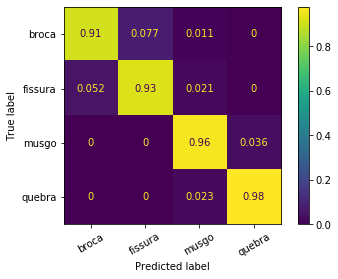

Rodada 1	-	Seed 7060
              precision    recall  f1-score   support

       broca       0.97      0.90      0.93        86
     fissura       0.90      0.98      0.94        84
       musgo       0.97      0.99      0.98        96
      quebra       0.99      0.97      0.98        92

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



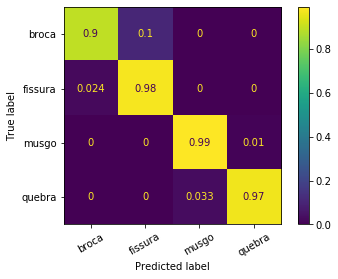

Rodada 2	-	Seed 7001
              precision    recall  f1-score   support

       broca       0.98      0.91      0.94       102
     fissura       0.91      0.97      0.94        96
       musgo       0.89      0.93      0.91        67
      quebra       0.95      0.92      0.93        93

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



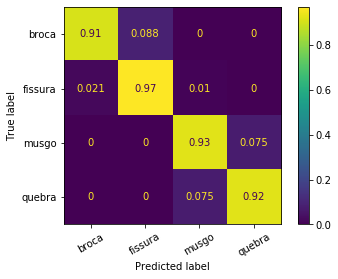

Rodada 3	-	Seed 4301
              precision    recall  f1-score   support

       broca       0.92      0.94      0.93        81
     fissura       0.96      0.90      0.93       101
       musgo       0.96      0.96      0.96        91
      quebra       0.93      0.98      0.95        85

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



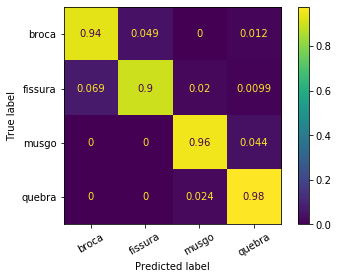

Rodada 4	-	Seed 5421
              precision    recall  f1-score   support

       broca       0.99      0.91      0.95        96
     fissura       0.89      0.99      0.93        80
       musgo       0.96      0.95      0.96        85
      quebra       0.97      0.97      0.97        97

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



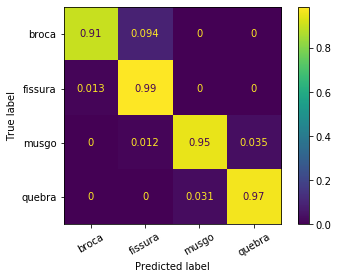

Rodada 5	-	Seed 5412
              precision    recall  f1-score   support

       broca       0.98      0.86      0.91        97
     fissura       0.86      0.98      0.91        85
       musgo       0.93      0.98      0.95        90
      quebra       0.98      0.92      0.95        86

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



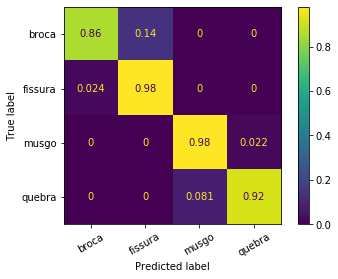

Rodada 6	-	Seed 4306
              precision    recall  f1-score   support

       broca       0.95      0.90      0.92        89
     fissura       0.90      0.93      0.92        89
       musgo       0.92      0.95      0.94        87
      quebra       0.96      0.95      0.95        93

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



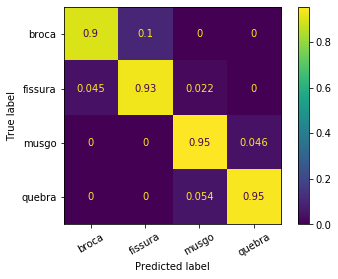

Rodada 7	-	Seed 4508
              precision    recall  f1-score   support

       broca       0.97      0.89      0.93        79
     fissura       0.91      0.98      0.94        89
       musgo       0.94      0.98      0.96        95
      quebra       0.98      0.94      0.96        95

    accuracy                           0.95       358
   macro avg       0.95      0.94      0.95       358
weighted avg       0.95      0.95      0.95       358



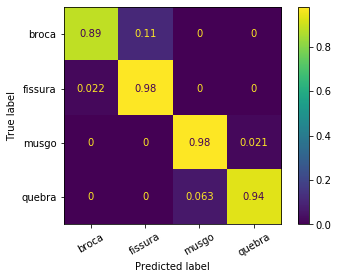

Rodada 8	-	Seed 3039
              precision    recall  f1-score   support

       broca       0.98      0.89      0.93        94
     fissura       0.90      0.95      0.92        91
       musgo       0.92      0.96      0.94        83
      quebra       0.96      0.94      0.95        90

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



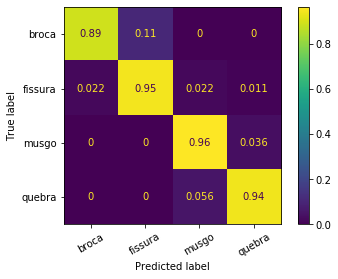

Rodada 9	-	Seed 2412
              precision    recall  f1-score   support

       broca       0.97      0.86      0.91        99
     fissura       0.84      0.96      0.90        81
       musgo       0.96      1.00      0.98        87
      quebra       1.00      0.95      0.97        91

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



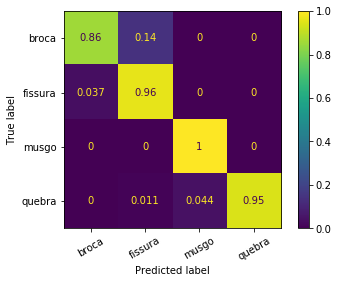

Rodada 10	-	Seed 5355
              precision    recall  f1-score   support

       broca       0.98      0.91      0.94        88
     fissura       0.91      0.98      0.94        86
       musgo       0.98      1.00      0.99       100
      quebra       1.00      0.98      0.99        84

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



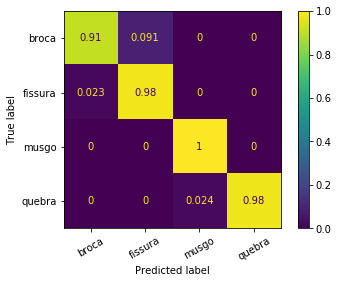

Rodada 11	-	Seed 6498
              precision    recall  f1-score   support

       broca       0.97      0.88      0.92        96
     fissura       0.89      0.97      0.93        92
       musgo       0.96      0.99      0.97        90
      quebra       0.99      0.96      0.97        80

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



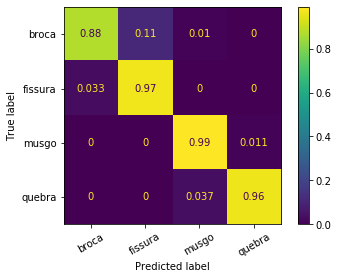

Rodada 12	-	Seed 6393
              precision    recall  f1-score   support

       broca       0.97      0.91      0.94        97
     fissura       0.91      0.95      0.93        82
       musgo       0.96      0.99      0.97        86
      quebra       0.98      0.97      0.97        93

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



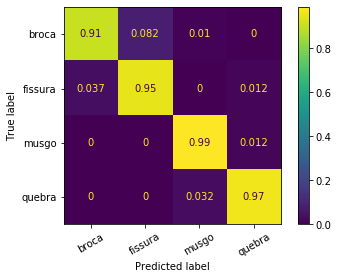

Rodada 13	-	Seed 1504
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96       100
     fissura       0.93      0.97      0.95        95
       musgo       0.90      0.93      0.91        84
      quebra       0.92      0.91      0.92        79

    accuracy                           0.94       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.94      0.94      0.94       358



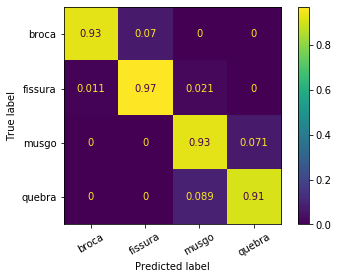

Rodada 14	-	Seed 7131
              precision    recall  f1-score   support

       broca       0.98      0.91      0.95        94
     fissura       0.93      0.97      0.95        93
       musgo       0.95      1.00      0.98        80
      quebra       0.99      0.97      0.98        91

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



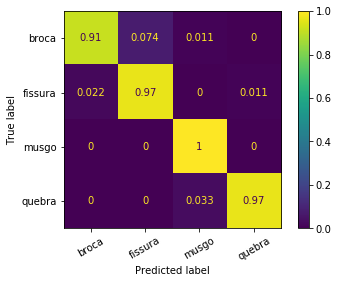

Rodada 15	-	Seed 7778
              precision    recall  f1-score   support

       broca       0.95      0.87      0.91        99
     fissura       0.86      0.93      0.89        82
       musgo       0.92      0.97      0.94        90
      quebra       0.96      0.93      0.95        87

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



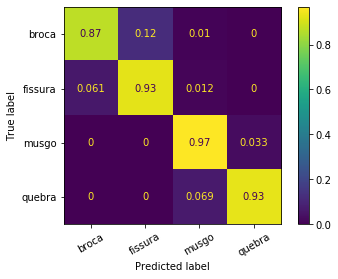

Rodada 16	-	Seed 2118
              precision    recall  f1-score   support

       broca       0.93      0.90      0.92        79
     fissura       0.93      0.93      0.93       103
       musgo       0.94      0.98      0.96        94
      quebra       0.96      0.95      0.96        82

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



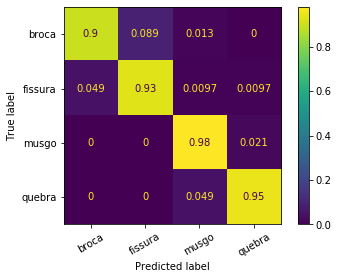

Rodada 17	-	Seed 7524
              precision    recall  f1-score   support

       broca       0.95      0.90      0.92        88
     fissura       0.92      0.96      0.94        95
       musgo       0.92      0.97      0.94        93
      quebra       0.96      0.91      0.94        82

    accuracy                           0.94       358
   macro avg       0.94      0.93      0.94       358
weighted avg       0.94      0.94      0.94       358



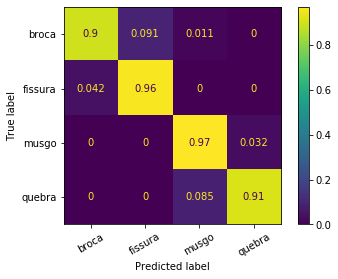

Rodada 18	-	Seed 221
              precision    recall  f1-score   support

       broca       0.95      0.87      0.91        85
     fissura       0.88      0.94      0.91        89
       musgo       0.93      0.96      0.94        93
      quebra       0.96      0.93      0.94        91

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



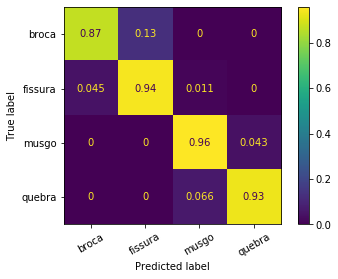

Rodada 19	-	Seed 2116
              precision    recall  f1-score   support

       broca       0.96      0.89      0.92       100
     fissura       0.90      0.93      0.91        92
       musgo       0.94      0.99      0.96        78
      quebra       0.98      0.97      0.97        88

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



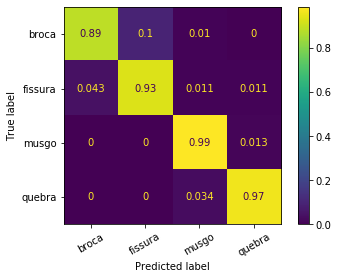

Rodada 20	-	Seed 7104
              precision    recall  f1-score   support

       broca       0.97      0.90      0.93        98
     fissura       0.90      0.95      0.93        88
       musgo       0.94      0.95      0.95        88
      quebra       0.95      0.96      0.96        84

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



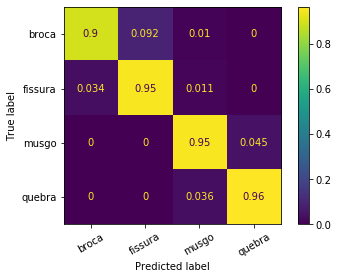

Rodada 21	-	Seed 700
              precision    recall  f1-score   support

       broca       0.91      0.91      0.91        85
     fissura       0.91      0.89      0.90        89
       musgo       0.90      0.98      0.94        92
      quebra       0.98      0.91      0.94        92

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



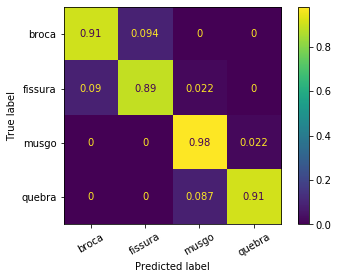

Rodada 22	-	Seed 7897
              precision    recall  f1-score   support

       broca       0.96      0.92      0.94        85
     fissura       0.93      0.96      0.94        96
       musgo       0.94      0.98      0.96        89
      quebra       0.98      0.94      0.96        88

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



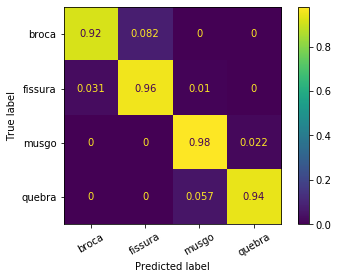

Rodada 23	-	Seed 6825
              precision    recall  f1-score   support

       broca       0.93      0.91      0.92        74
     fissura       0.92      0.93      0.92        86
       musgo       0.98      0.99      0.98        96
      quebra       0.98      0.98      0.98       102

    accuracy                           0.96       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.96      0.96      0.96       358



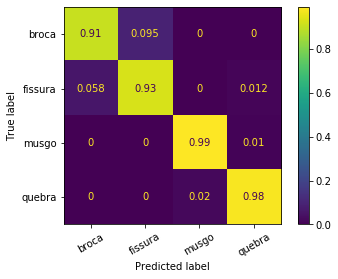

Rodada 24	-	Seed 2899
              precision    recall  f1-score   support

       broca       0.96      0.86      0.91        86
     fissura       0.88      0.95      0.91        94
       musgo       0.96      0.97      0.96        91
      quebra       0.95      0.97      0.96        87

    accuracy                           0.94       358
   macro avg       0.94      0.93      0.94       358
weighted avg       0.94      0.94      0.94       358



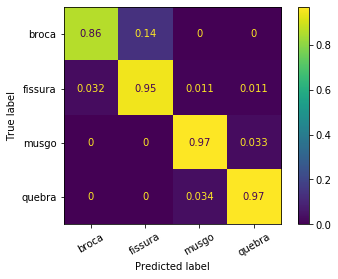

Rodada 25	-	Seed 5077
              precision    recall  f1-score   support

       broca       0.94      0.90      0.92        97
     fissura       0.89      0.93      0.91        85
       musgo       0.93      0.98      0.95        83
      quebra       0.98      0.94      0.96        93

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



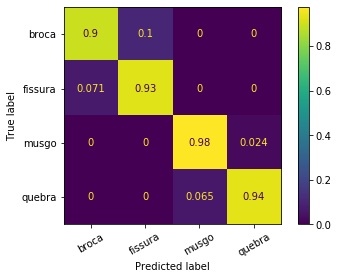

Rodada 26	-	Seed 4857
              precision    recall  f1-score   support

       broca       0.95      0.90      0.92        86
     fissura       0.91      0.95      0.93        92
       musgo       0.95      0.98      0.96        90
      quebra       0.98      0.96      0.97        90

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



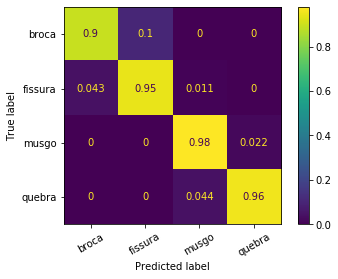

Rodada 27	-	Seed 4394
              precision    recall  f1-score   support

       broca       0.95      0.91      0.93        90
     fissura       0.92      0.95      0.93        92
       musgo       0.92      0.99      0.96        86
      quebra       0.99      0.93      0.96        90

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.95      0.94      0.94       358



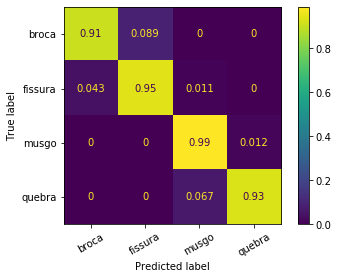

Rodada 28	-	Seed 2906
              precision    recall  f1-score   support

       broca       0.99      0.88      0.93        93
     fissura       0.91      0.97      0.94        91
       musgo       0.93      0.97      0.95        80
      quebra       0.96      0.96      0.96        94

    accuracy                           0.94       358
   macro avg       0.95      0.95      0.94       358
weighted avg       0.95      0.94      0.94       358



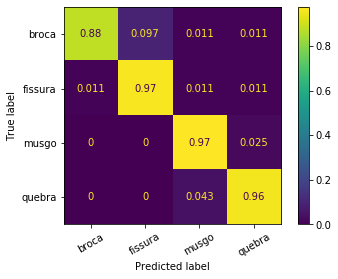

Rodada 29	-	Seed 3396
              precision    recall  f1-score   support

       broca       0.96      0.91      0.94        89
     fissura       0.91      0.93      0.92        85
       musgo       0.91      0.97      0.94        92
      quebra       0.96      0.92      0.94        92

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



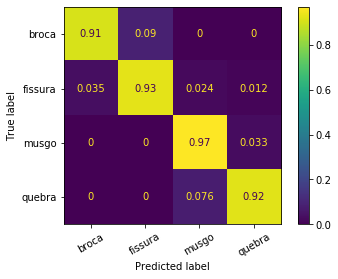

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_norm2_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

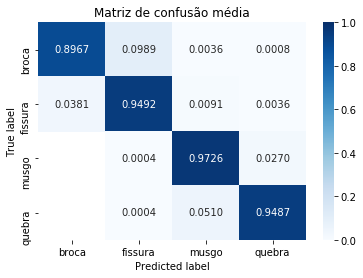

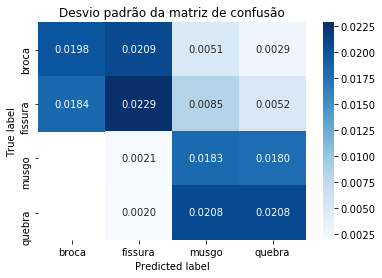

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia   f1-broca  f1-fissura   f1-musgo  f1-quebra
count  30.000000  30.000000   30.000000  30.000000  30.000000
mean    0.941527   0.926644    0.925558   0.954437   0.958432
std     0.010829   0.013529    0.014788   0.018968   0.015746
min     0.921788   0.905263    0.894118   0.905109   0.917197
25%     0.933659   0.916549    0.915452   0.941951   0.947956
50%     0.941341   0.926991    0.927630   0.955550   0.958013
75%     0.946927   0.935461    0.936900   0.962312   0.971429
max     0.966480   0.958763    0.948454   0.990099   0.987952


Acurácia,f1-broca,f1-fissura,f1-musgo,f1-quebra
0.944134,0.927374,0.927083,0.952941,0.971429
0.958101,0.933333,0.937143,0.979381,0.978022
0.932961,0.944162,0.939394,0.905109,0.934783
0.941341,0.926829,0.928571,0.956044,0.954023
0.952514,0.945652,0.934911,0.958580,0.969072
0.930168,0.912088,0.912088,0.951351,0.946108
0.932961,0.924855,0.917127,0.937853,0.951351
0.946927,0.927152,0.940541,0.958763,0.956989
0.935754,0.933333,0.919786,0.941176,0.949721
0.938547,0.909091,0.896552,0.977528,0.971751


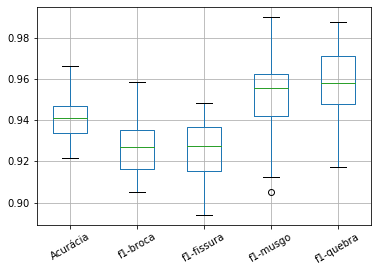

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')